In [26]:
# Loading datasets and libraries

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from numpy import random

In [96]:
df = pd.read_csv('Train_set.csv')

In [29]:
# Preproccesing

In [116]:
def expand_linear(time_series):
  left = 0
  right = 0
  for k in range(1, len(time_series)):
    if time_series[k] == 0:
      left = time_series[k-1]
      l = 0
      while time_series[k+l] == 0:
        l+=1
        if len(time_series) == k+l:
          return time_series
      right = time_series[k+l]
      time_series[k: k+l] = np.linspace(left, right, num=l+2)[1:(l+1)]
  return time_series
      

In [107]:
# Simple idea of putting 0
df.fillna(0, inplace = True)

In [114]:
# Separate the ID and class columns from the input features
ids = df['ID']
y = df['Class']
y = np.array(y)
X = df.drop(['ID', 'Class'], axis=1)
X = np.array(X)

In [117]:
for k in range(X.shape[0]):
  expand_linear(X[k,:])

In [121]:
# Standardize the input features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [122]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

In [123]:
class Attention(nn.Module):

    def __init__(self, hidden_dim, dimx):
        
      super().__init__()
      self.dimx = dimx
      self.Q = nn.Linear(hidden_dim, dimx, bias = False) # 1 for dimension of x - one value
      self.K = nn.Linear(hidden_dim, dimx, bias = False)
      self.V = nn.Linear(hidden_dim, dimx, bias = False)
      self.softmax = nn.Softmax(dim = 1)

    def forward(self, x):
      queries = self.Q(x[-1,:]).view(-1,1)
      keys = self.K(x)
      values = torch.transpose(self.V(x),0,1)
      preweights = torch.matmul(keys, queries) / np.sqrt(self.dimx)
      weights = self.softmax(preweights)
      embeddings = torch.matmul(values, weights)
      return embeddings

In [124]:
class RNN(nn.Module):
    def __init__(self, dimx, output_size, hidden_dim, n_layers = 1,drop=0.5):
        
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dimx = dimx
        # Attention
        self.attention = Attention(hidden_dim, dimx)
        # LSTM layer
        self.rnn = nn.LSTM(1, hidden_dim, n_layers)
        
        # last, fully-connected layer
        self.fc1 = nn.Linear(dimx, output_size) 
        self.logsoftmax = nn.LogSoftmax(dim=0) 
        
        # Capa dropout 
        self.dropout = nn.Dropout(p=drop)

    def forward(self, x):

        '''
        - x: Sequences of word embeddings. Dimensions (#no batch, max_l, word_embedding_size)
        - lengths: The real length of each sequence, excluding the junk # tokens! You use this to know what
          RNN state you should use to classify
        '''
        #x = x.reshape(x.size(0))
        # Compute the RNN output (sequence of states for the whole input)
        states, _ =  self.rnn(x)
        x = self.attention.forward(states).flatten()
        x_drop = self.dropout(x)
        x_out = self.fc1(x_drop)
        # We classify using such tensor (don't forget the dropout!)
        output = self.logsoftmax(x_out)
        return output

    def forward_test(self, x):

        x = np.trim_zeros(x, 'b')
        x = torch.Tensor(x).view(-1,1)
        x = x.to(torch.float32)
        x = x.to(self.device)
        states, _ =  self.rnn(x)
        x = self.attention.forward(states).flatten()
        x_drop = self.dropout(x)
        x_out = self.fc1(x_drop)
        # We classify using such tensor (don't forget the dropout!)
        output = self.logsoftmax(x_out)
        return output

In [125]:
class RNN_with_train(RNN):
    
    def __init__(self,dimx, output_size, hidden_dim, n_layers,drop=0.0,batch_size=5000,lr=0.0005,saved_files='./saved_models/RNN_sentiment_analysis'):
        
        super().__init__(dimx, output_size, hidden_dim, n_layers,drop)  
        
        self.lr = lr # Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr) # Optimizer
        
        self.criterion = nn.NLLLoss()              
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = [] 
        
        self.batch_size = batch_size
        
        self.saved_files = saved_files

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.to(self.device)
            
        
    def trainloop(self, X_train, X_val, Y, Y_val,epochs=100,print_every=3):
        
        self.print_every = print_every
        self.epochs=epochs

        # Optimization Loop

        #labels = torch.Tensor(Y).type(torch.LongTensor) # Training labels
        
        #labelsval = torch.Tensor(Yval).type(torch.LongTensor) # Validation labels
        
        ### WE ARE HERE
        for e in range(int(self.epochs)):

          for b in range(int(self.batch_size)):
            
            self.train() # Activate dropout
  
            # Random data sample, we even out class imbalances during training!
            #class_number = random.randint(5) # label
            class_number = np.random.choice(5, 1, p=[0.4, 0.15, 0.15, 0.15, 0.15])[0]
            idx = random.choice(np.nonzero(Y == class_number)[0]) # choose element to train given a label
            
            running_loss = 0.
            self.optim.zero_grad() 
            x = X_train[idx,:]
            x = np.trim_zeros(x, 'b')
            x = torch.Tensor(x).view(-1,1)
            x = x.to(torch.float32)
            x = x.to(self.device)
            out = self.forward(x)
            label = torch.Tensor([class_number]).type(torch.LongTensor)
            loss = self.criterion(out.view(1,-1),label)
            running_loss += loss.item()
            loss.backward()
            # Gradient clipping
            nn.utils.clip_grad_norm_(self.parameters(), 2.0)
            # SGD steps
            self.optim.step()
        
          self.loss_during_training.append(running_loss) # no self batch size to better see
            

            
# REAPEAT for valid
          with torch.no_grad(): 
              
            # set model to evaluation mode
            self.eval()
            running_loss = 0.

            for b in range(int(self.batch_size)):
  
              class_number = np.random.choice(5, 1, p=[0.4, 0.15, 0.15, 0.15, 0.15])[0]
              idx = random.choice(np.nonzero(Y_val == class_number)[0]) # choose element to train given a label
              running_loss = 0.
              x = X_val[idx,:]
              x = np.trim_zeros(x, 'b')
              x = torch.Tensor(x).view(-1,1)
              x = x.to(torch.float32)
              x = x.to(self.device)
              out = self.forward(x)
              label = torch.Tensor([class_number]).type(torch.LongTensor)
              label = label.to(self.device)
              loss = self.criterion(out.view(1,-1),label)
              running_loss += loss.item()

          self.valid_loss_during_training.append(running_loss)
          if(e % self.print_every == 0): 
            print(f"Training loss after {e} epochs: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}")
            # We save model parameters  
            torch.save(self.state_dict(), self.saved_files+'_epoch_'+str(e)+'.pth')

In [147]:
#rnn = RNN_with_train(10,5,8,1,0.3, batch_size = 50000, lr = 0.000001) # 50 000 is half the data set
rnn.trainloop(X_train, X_val, y_train, y_val,epochs=40, print_every=1) # idk how many epochs

Training loss after 0 epochs: 0.048727672547101974. Validation loss: 0.010740566998720169
Training loss after 1 epochs: 0.5430446267127991. Validation loss: 0.00033539868309162557
Training loss after 2 epochs: 0.0005448763840831816. Validation loss: 5.1973900554003194e-05
Training loss after 3 epochs: 0.9563352465629578. Validation loss: 0.0033993099350482225
Training loss after 4 epochs: 0.0013603252591565251. Validation loss: 0.005652989260852337
Training loss after 5 epochs: 0.055028315633535385. Validation loss: 0.0005544078885577619
Training loss after 6 epochs: 0.00036864637513644993. Validation loss: 2.2053474822314456e-05
Training loss after 7 epochs: 1.4305104514278355e-06. Validation loss: 0.005755637306720018
Training loss after 8 epochs: 0.00012563870404846966. Validation loss: 1.3128538131713867
Training loss after 9 epochs: 0.00013064485392533243. Validation loss: 1.8358061424805783e-05
Training loss after 10 epochs: 0.012727932073175907. Validation loss: 0.00143889326136

KeyboardInterrupt: ignored

<function matplotlib.pyplot.show(close=None, block=None)>

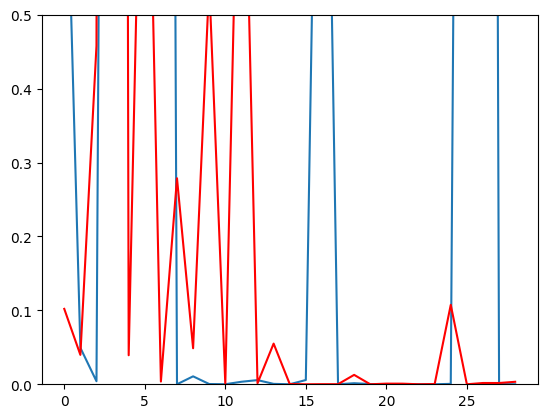

In [151]:
plt.plot(rnn.valid_loss_during_training)
plt.plot(rnn.loss_during_training, color = "red")
plt.ylim([0,0.5])
plt.show

In [162]:
rnn = RNN_with_train(10,5,8,1,0.3, batch_size = 50000)
state_dict = torch.load("/content/saved_models/RNN_sentiment_analysis_epoch_19.pth")
rnn.load_state_dict(state_dict)

<All keys matched successfully>

In [165]:
df2 = pd.read_csv('Test_set.csv')
df2.fillna(0, inplace = True)
# Separate the ID and class columns from the input features
ids = df2['ID']
X_test = df2.drop(['ID'], axis=1)
X_test = np.array(X_test)
for k in range(X_test.shape[0]):
  expand_linear(X_test[k,:])
# Standardize the input features
#X_test = scaler.transform(X_test)
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)
pred_classes = [torch.argmax(rnn.forward_test(X_test[k,:])) for k in range(X_test.shape[0])]
pred_classes = np.array(pred_classes)

# Create a new pandas DataFrame with the predicted classes and an ID column (if necessary)
ids = np.arange(len(pred_classes))
results = pd.DataFrame({'ID': ids, 'Pred_Class': pred_classes})

# Save the DataFrame as a CSV file
results.to_csv('sub_30-04.csv', index=False)

# 0 class
sum(pred_classes ==0)

17036

In [ ]:
results.head()

In [134]:
gabriele = pd.read_csv('sample_submission_deep.csv')

In [164]:
sum(gabriele["Pred_Class"] == results["Pred_Class"])

18971